<a href="https://colab.research.google.com/github/tylerpan98/NLP-translation-Kaggle-Intro-Project/blob/main/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Translation Project/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Translation Project/'
/content/drive/MyDrive/GHED


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

In [ ]:
data = pd.read_csv('eng_-french.csv')


In [ ]:
data.head(5)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [ ]:
data.describe()

,English words/sentences,French words/sentences
count,175621,175621
unique,123100,165975
top,I can't tell you how happy I am that you've co...,Merci bien.
freq,32,9


In [ ]:
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
data = data.rename(columns = {"English words/sentences":"english", "French words/sentences":"french"})

In [ ]:
data = data.assign(
    English_Count=data['english'].apply(lambda x: len(x.split())),
    French_Count=data['french'].apply(lambda x: len(x.split()))
)
print(f"{data['English_Count'].sum()} English Words")
print(f"{data['French_Count'].sum()} French Words")

1082098 English Words
1177832 French Words


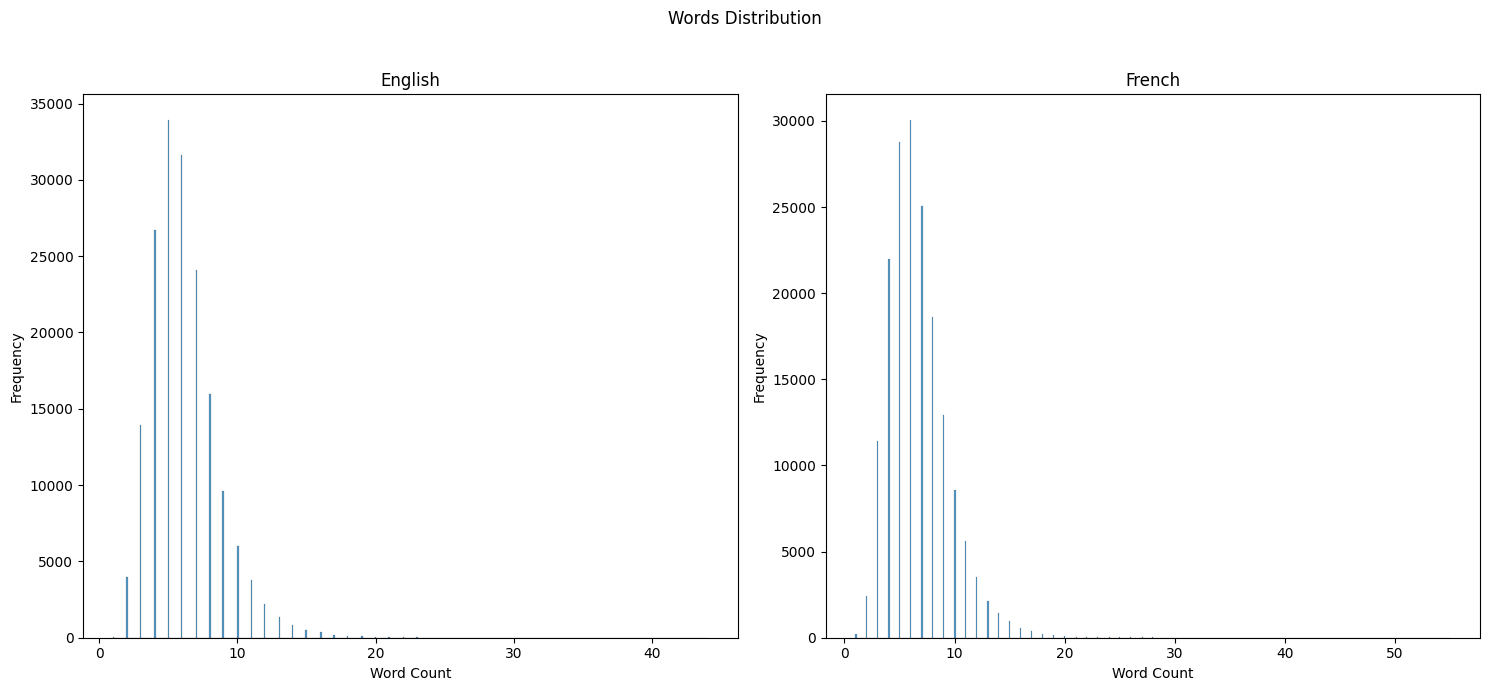

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle('Words Distribution')

sns.histplot(data['English_Count'], ax=axes[0])
axes[0].set_title('English')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

sns.histplot(data['French_Count'], ax=axes[1])
axes[1].set_title('French')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [ ]:
from wordcloud import WordCloud


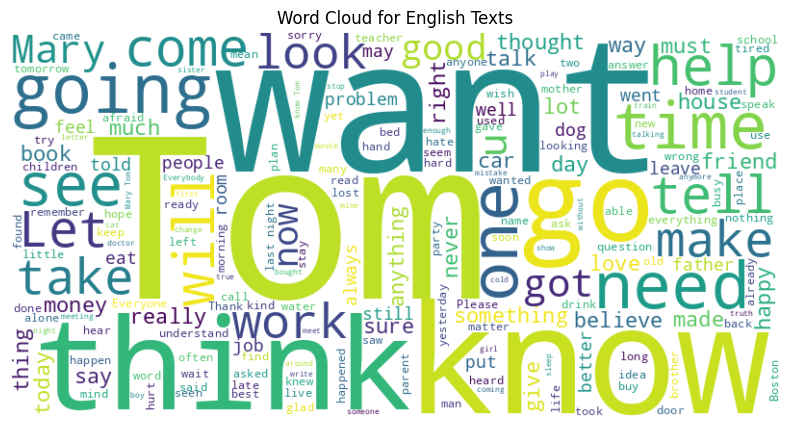

In [ ]:
english_combined_text = ' '.join(data['english'])
wordcloud_eng = WordCloud(width=800, height=400, background_color='white').generate(english_combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_eng, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for English Texts')
plt.show()

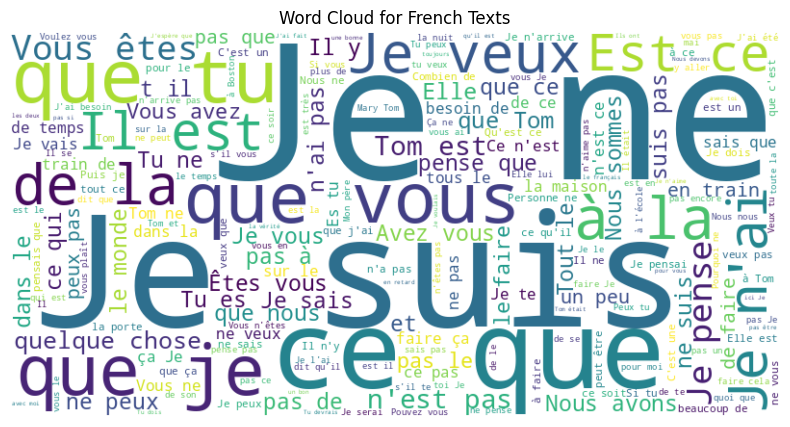

In [ ]:
french_combined_text = ' '.join(data['french'])
wordcloud_french = WordCloud(width=800, height=400, background_color='white').generate(french_combined_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_french, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for French Texts')
plt.show()

In [ ]:
def tokenize(x):
  x_tk = Tokenizer(char_level = False)
  x_tk.fit_on_texts(x)
  return x_tk.texts_to_sequences(x), x_tk

In [ ]:
def pad(x, length=None):
  if length is None:
    length = max([len(sentence) for sentence in x])
  return pad_sequences(x, maxlen = length, padding = 'post')

In [ ]:
eng_seq, eng_tok = tokenize(data['english'])
eng_vocab_size = len(eng_tok.word_index)+1
frn_seq, frn_tok = tokenize(data['french'])
frn_vocab_size = len(frn_tok.word_index)+1

print('Complete Enlish vocab size:', eng_vocab_size)
print('Complete French vocab size:', frn_vocab_size)

Complete Enlish vocab size: 14532
Complete French vocab size: 30661


In [ ]:
eng_len = max([len(sentence) for sentence in eng_seq])
frn_len = max([len(sentence) for sentence in frn_seq])


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state = 0)

In [ ]:
train_data = train_data.drop(columns=['English_Count', 'French_Count'],axis=1)
test_data = test_data.drop(columns=['English_Count', 'French_Count'],axis=1)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
train_X_seq, train_X_tok = tokenize(train_data['english'])
train_Y_seq, train_Y_tok = tokenize(train_data['english'])

train_eng_vocab = len(train_X_tok.word_index) + 1
train_frn_vocab = len(train_Y_tok.word_index) + 1

test_X_seq, test_X_tok = tokenize(test_data['english'])
test_Y_seq, test_Y_tok = tokenize(test_data['french'])

test_eng_vocab = len(test_X_tok.word_index) + 1
test_frn_vocab = len(test_Y_tok.word_index) + 1

train_X_seq = pad(train_X_seq)
train_Y_seq = pad(train_Y_seq)

test_X_seq = pad(test_X_seq)
test_Y_seq = pad(test_Y_seq)

In [ ]:
from tabulate import tabulate

tab_data = [["Train", train_eng_vocab, train_frn_vocab],["Test",test_eng_vocab,test_frn_vocab]]
print(tabulate(tab_data, headers=['Dataset','Eng Vocab Size','Frn Vocab Size'], tablefmt="pretty"))

+---------+----------------+----------------+
| Dataset | Eng Vocab Size | Frn Vocab Size |
+---------+----------------+----------------+
|  Train  |     14068      |     14068      |
|  Test   |      6166      |     10502      |
+---------+----------------+----------------+


In [ ]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps, btch_size):

    model = Sequential()
    model.add(Embedding(in_vocab, btch_size, input_length=in_timesteps, mask_zero=True))

    model.add(LSTM(btch_size))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(btch_size, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [ ]:
batch_size = 64
lr = 1e-3

model = define_model(eng_vocab_size, frn_vocab_size, eng_len, frn_len, batch_size)

model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr))

In [ ]:
fn = 'model.h1.MT'
epoch = 2
val_split = 0.1

checkpoint = ModelCheckpoint(fn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(train_X_seq, train_Y_seq,
                    epochs=epoch, batch_size=batch_size, validation_split = val_split, callbacks=[checkpoint],
                    verbose=1)

Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-154-c82517471330>", line 7, in <cell line: 7>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

assertion failed: [Condition x == y did not hold element-wise:] [x (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [64 44] [y (sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [64 55]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert}}]] [Op:__inference_train_function_9701]